These examples show how to analyze and visualize results after running the $py$GWBSE workflow. You need to first run the `create_workflow.ipynb` example to create and execute the workflow and then you can run these examples. All the output results are automatically stored by $py$GWBSE in the GW-BSE database so this example needs to access the database to run. 

Let's start by loading the required libraries such as matplotlib and pymongo 

In [1]:
from pymongo import MongoClient
import matplotlib.pyplot as plt
import numpy as np

We have to specify details of the database we have used earlier to create and run the $py$GWBSE workflow.

In [2]:
#hostname = <address of the database>
#port = <port number>
#username = <user name>
#password = <user password> 
#dbname = <name of the database>

Now we can connect to the database using pymongo.

In [4]:
client = MongoClient(hostname, port)
db = client[dbname]
db.authenticate(username, password)

True

First let's analyze the results for AlN workflow. As you might remember `mp-661` has been used as the unique identifier for AlN in the database when we created the workflow earlier using `create_workflow.ipynb`.

In [5]:
mid='mp-661'

Let's check how the convergence calculation went,

In [6]:
eqpcollection = db.get_collection('QP_Results')
for x in eqpcollection.find({'material_id': mid, "task_label": { "$regex": 'Convergence'}}):
    tl=x["task_label"]
    nbands=x["incar"]["NBANDS"]
    gap=x["indirect_gap"]
    ifconv=x['ifconv']
    print(tl, nbands, '%5.2f' %gap, ifconv)

Convergence_Iteration: 1 65  5.55 False
Convergence_Iteration: 2 91  5.59 True


As you can see the workflow computed QP gap using NBANDS value of 65 and 91 and found that the gap didn't change by more than 0.1. As a result the Firework set `ifconv` tag to True and stopped. 

We can also check what was the effect of partial self-consistent iterations on the QP gap

In [7]:
eqpcollection = db.get_collection('QP_Results')
for x in eqpcollection.find({'material_id': mid, "task_label": { "$regex": 'scGW'}, 'job_tag': 'GW0'}):
    tl=x["task_label"]
    gap=x["indirect_gap"]
    ifconv=x['ifconv']
    print(tl, '%5.2f' %gap, ifconv)

scGW_Iteration: 1  5.59 False
scGW_Iteration: 2  6.08 False
scGW_Iteration: 3  6.24 False
scGW_Iteration: 4  6.28 True


As you can see the workflow continued the partial self-consistent (GW$_0$) calculation untill the QP gap is converged within 0.1 eV. After that the Firework set `ifconv` tag to True and stopped. The QP gap of AlN at the G$_0$W$_0$ level turns out to be 5.59 eV and it is 6.28 eV at the GW$_0$ level.

Now let's retrieve the data to plot DFT bandstructure computed by VASP and compare it with wannier extrapolated bandstructure. 

In [8]:
collection = db.get_collection('WANNIER_Results')
for x in collection.find({'task_label' : "CHECK_WANNIER_INTERPOLATION", 'material_id' : mid}):

    kpts=np.array(x["wannier_kpoints"]) 
    #x coordinates of energy values to plot bandstructure

    eigs_wann=np.array(x["wannier_eigenvalues"]) 
    #wannier interpolated energies to plot bandstructure
    
    eigs_vasp=np.transpose(np.array(x["actual_eigenvalues"])) 
    #vasp computed energies to plot bandstructure 
    
    spkptls=x["special_kpoint_labels"] 
    #labels of special k-points in the bandstructure    
    spkptcs=x["special_kpoint_coordinates"] 
    #x coordinates of special  k-points in the bandstructure 

Here is generic function to plot the bandstructure  

In [9]:
def plot_bandstructure(kpts,eigs,spkptls,spkptcs,cl,lb,ls,lw):
    
    """
    kpts: 1-D array of x coordinates of energy values to plot bandstructure
    eigs: 2-D array (band index, k-point index) of energies to plot bandstructure 
    spkptls: 1-D array of labels of special k-points in the bandstructure 
    spkptcs: 1-D array of x coordinates of special k-points in the bandstructure 
    """
    
    nb=np.shape(eigs)[0]
    for j in range(nb):
        if j==0:
            plt.plot(kpts, eigs[j,:], c=cl, lw=lw, label=lb, ls=ls)
        else:
            plt.plot(kpts, eigs[j,:], c=cl, lw=lw, ls=ls)
    for spkptc in spkptcs:
        plt.axvline(spkptc,lw=2,c='k')

    plt.ylabel(r'E-E$_{VBM}$')
    plt.xticks(spkptcs, spkptls)
    plt.xlim(spkptcs[0],max(spkptcs))

We need to modify special characters like $\Gamma$ in a format suitable for matplotlib 

In [10]:
print(spkptls)
spkptls = [r'$\Gamma$' if item == '\\GAMMA' else item for item in spkptls]
print(spkptls)

['\\GAMMA', 'M', 'K', '\\GAMMA', 'A', 'L', 'H', 'A|L', 'M|K', 'H']
['$\\Gamma$', 'M', 'K', '$\\Gamma$', 'A', 'L', 'H', 'A|L', 'M|K', 'H']


Now let's use `plot_bandstructure` function to check how good the wannier interpolation is 

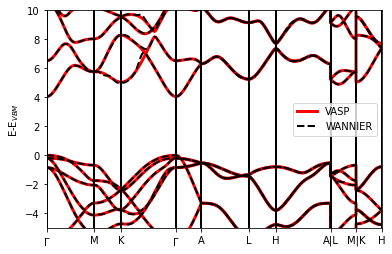

In [11]:
plot_bandstructure(kpts[0,:],eigs_vasp,spkptls,spkptcs,'r','VASP','-',3)
plot_bandstructure(kpts[0,:],eigs_wann,spkptls,spkptcs,'k','WANNIER','--',2)
plt.ylim(-5,10)
plt.legend()
plt.show()

Looks like the wannier interpolation is pretty accurate. The bandstructure from wannier interpolation reproduces the bandstructure obtained from VASP calculation throughout the Brillouin zone (BZ).

Now let's retrieve the wannier interpolated QP energies to plot GW bandstructure 

In [12]:
collection = db.get_collection('WANNIER_Results')
for x in collection.find({'task_label' : "GW_BANDSTRUCTURE", 'material_id' : mid}):
    eigs_gw=np.array(x["wannier_eigenvalues"]) #wannier interpolated QP energies to plot GW bandstructure

Let's use the `plot_bandstructure` function and compare the DFT vs GW bandstructure

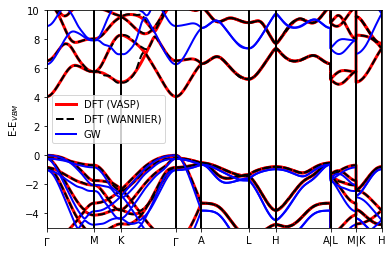

In [13]:
fig, ax = plt.subplots(facecolor='w')
plot_bandstructure(kpts[0,:],eigs_vasp,spkptls,spkptcs,'r','DFT (VASP)','-',3)
plot_bandstructure(kpts[0,:],eigs_wann,spkptls,spkptcs,'k','DFT (WANNIER)','--',2)
plot_bandstructure(kpts[0,:],eigs_gw,spkptls,spkptcs,'b','GW','-',2)
plt.ylim(-5,10)
plt.legend()
plt.show()

Now let's retrieve the projections of KS orbitals on atomic orbitals which can be used to plot orbital resolved DOS (PDOS)

In [14]:
eqpcollection = db.get_collection('EPS_Results')
for x in eqpcollection.find({"material_id": mid}):
    proj_eig=x["projected_eigs"] #projections of KS orbitals on atomic orbitals
    eigs=x["ks_energies"] #KS energies  
    vbm=x["vbm"] #valence band maxima
    kwg=x["kpoint_weights"] #weights of symmetry reduced k-points

    
#This was a non spin polarized calculation so there is only one spin index
for spin, v in proj_eig.items():
    peig=np.array(v)

for spin, v in eigs.items():
    eig=np.array(v)

#setting the VBM as zero in energy axis
eig=np.array(eig)-vbm

To obtain PDOS from projection of KS wavefunction onto atomic oribitals we have written the following functions

In [15]:
#Gaussian Function
def gaussian(x,x0,sigma):
    y = (1 / sigma*np.sqrt(2 * np.pi)) * np.exp(-((x-x0)/sigma) ** 2 / 2.)
    return y

#Function to compute PDOS from projections

def calc_pdos(ias,ios,peig,eig,kwg,enmin,enmax,n,sigma):
    """
    
    Args:
    
    ias: list of atom indices to be included in PDOS
    ios: list of orbital indices to be included in PDOS
    peig: 4-D array (k-point index, band_index, atom_index, orbital_index) 
            contaning projections of KS wavefunctions on atomic oritals
    eig: 2-D array (k-point index, band index) of energy eigenvalues
    kwg: 1-D array of k-point weights
    enmin: minimum of the energy window to plot PDOS
    enmax: maximum of the energy window to plot PDOS
    n: number of energy values to be used in PDOS 
    sigma: width of the Gaussian smearing 
    
    Returns:
    
    x: energy values   
    t: total DOS
    y: PDOS
    
    """
    nk=np.shape(peig)[0]
    nb=np.shape(peig)[1]
    na=np.shape(peig)[2]
    no=np.shape(peig)[3]
    ens=np.linspace(enmin,enmax,num=n)

    x=[]
    y=[]
    t=[]
    for en in ens:
        den=0
        ten=0
        for ik in range(nk):
            for ib in range(nb):
                eigv=eig[ik][ib][0]
                smr=gaussian(eigv,en,sigma)
                ten=ten+smr*kwg[ik]
                for ia in ias:
                    for io in ios:
                        den=den+peig[ik][ib][ia][io]*smr*kwg[ik]
        x.append(en)
        y.append(den/np.pi)
        t.append(ten/np.pi)
    return x,t,y

Now let's use the `calc_pdos` function we just defined to plot PDOS of Al(p) and N(p) states in AlN 

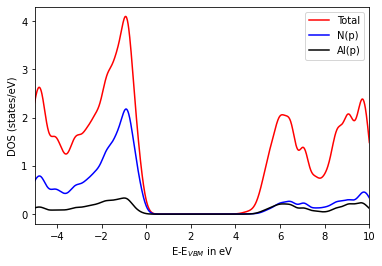

In [16]:
Al_list=[0,1] #atom 0 and 1 are Al
N_list=[2,3]  #atom 2 and 3 are N
orbital_list=[1,2,3] # orbital 1,2,3 are p- orbitals

#Other paramters to compute PDOS

enmin=-5 
enmax=10
num=1000
sigma=0.2

#Compute PDOS and total DOS
en,tdos,pdos_Al=calc_pdos(Al_list,orbital_list,peig,eig,kwg,enmin,enmax,num,sigma)
en,tdos,pdos_N=calc_pdos(N_list,orbital_list,peig,eig,kwg,enmin,enmax,num,sigma)
#Now we can plot PDOS and total DOS
plt.plot(en,tdos,label='Total',c='r')
plt.plot(en,pdos_N,label='N(p)',c='b')
plt.plot(en,pdos_Al,label='Al(p)',c='k')
plt.xlabel(r'E-E$_{VBM}$ in eV')
plt.ylabel('DOS (states/eV)')
plt.xlim(enmin,enmax)
plt.legend()
plt.show()

We can also use QP energies instead of KS energies to plot QP DOS/PDOS. To do that, first let's retreive QP energies and QP VBM from the database

In [17]:
eqpcollection = db.get_collection('QP_Results')
for x in eqpcollection.find({'material_id': mid, "task_label": { "$regex": 'scGW'}, 'ifconv': True}):
    eigs_gw=x["qp_energies"]
    vbm_gw=x["vbm"]
    
for spin, v in eigs_gw.items():
    eig_gw=np.array(v)

#setting the VBM of QP energies as zero in energy axis
eig_gw=np.array(eig_gw)-vbm_gw

#Compute PDOS and DOS with QP correction 

en,tdos_gw,pdos_gw=calc_pdos(N_list,orbital_list,peig,eig_gw,kwg,enmin,enmax,num,sigma)

#Now we can plot PDOS and total DOS with and without QP correction  

plt.plot(en,pdos_N,label='N(p)-DFT',c='b')
plt.plot(en,pdos_gw,label='N(p)-GW',c='r')
plt.xlabel(r'E-E$_{VBM}$ in eV')
plt.ylabel('DOS (states/eV)')
plt.xlim(enmin,enmax)
plt.legend()
plt.show()

IndexError: index 48 is out of bounds for axis 0 with size 48

Now Let's look at the static dielectric tensor of AlN computed at the DFT level 

In [ ]:
eqpcollection = db.get_collection('EPS_Results')
for x in eqpcollection.find({"material_id": mid}):
    dc=x['dielectric constant']
print(dc)

dielectric constant perpendicular to c-axis ($\epsilon^{\perp}_{\infty}$). Note that, because of hexagonal symmetry `dc[0][0]` and `dc[1][1]` is the same. 

In [ ]:
dc[0][0]

dielectric constant parallel to c-axis ($\epsilon^{\parallel}_{\infty}$)

In [ ]:
dc[2][2]

Next, let's look at the effective masses of AlN

In [ ]:
eqpcollection = db.get_collection('EMC_Results')
for x in eqpcollection.find({"material_id": mid}):
    hmass=x['hole_effective_mass']
    emass=x['electron_effective_mass']

`hmass` and `emass` are the dictionaries containing hole and electron
effective masses respectively. The keys for each effective mass values 
are constructed as (ibnd,dir1,dir2) where, ibnd is the index of the 
band from which the effective mass is computed in the direction from 
special k-point dir1 to special k-point dir2. 

In [ ]:
#hole effective masses 

for key, value in hmass.items():
    print(key, '%5.2f' %(value))

In [ ]:
#elctron effective masses 

for key, value in emass.items():
    print(key, '%5.2f' %value)

AlN has a hexagonal crystal structure. The VBM as well as the CBM is located at the $\Gamma$ point. Both the VBM (8$^{th}$ band) and CBM (9$^{th}$ band) in non-degenerate. From the bandstructure (computed earlier) we can see that there can be 3 special directions in the BZ along which the effective masses can be evaluated for the band edges. Which are, 

1. $\Gamma$ (0,0,0) $\rightarrow$ M (1/2,0,0)
2. $\Gamma$ (0,0,0) $\rightarrow$ K (1/3,1/3,0)
3. $\Gamma$ (0,0,0) $\rightarrow$ A (0,0,1/2)

First two directions are perpendicular to c-axis and will provide $m^{\perp}$ and the third is parallel to c-axis
and will provide $m^{\parallel}$

Now we will plot the absorption spectra of AlN from the results stored by workflow created by `create_workflow.ipynb` example.

First let's retrieve the data to plot the absorption spectra and analyze results from BSE calculation 

In [ ]:
mid='mp-661'

In [ ]:
eqpcollection = db.get_collection('BSE_Results')
for x in eqpcollection.find({"material_id": 'mp-661', 'job_tag': 'GW0-BSE'}):
    bfreq=x["frequency"] 
    #1-D array containing list of frequencies in eV
    
    beps1=x["epsilon_1"] 
    #Real part of the dielectric function at those frquencies
    
    beps2=x["epsilon_2"] 
    #Imaginary part of the dielectric function at those frquencies
    
    opt=x["optical_transition"] 
    #List of [en,os] where,en is the transition energies in eV and os is the corresponding oscillator strengths
    
    qpg=x["direct_gap"] 
    #direct QP gap

Each element (there are same number of such element as the number of frequency values in `bfreq`) of $beps1$ and $beps2$ contains six values which are ordered as $\epsilon^{xx}$, $\epsilon^{yy}$, $\epsilon^{zz}$, $\epsilon^{xy}$, $\epsilon^{yz}$, $\epsilon^{xz}$ 

In [ ]:
beps2[0]

Now let's compute the exciton binding energy of AlN 

In [ ]:
opg=opt[0][0]
ebe=qpg-opg
print('QP gap:','%5.2f' %qpg, 'Optical gap:','%5.2f' %opg, 'Exciton Binding Energy:','%5.2f' %ebe)

Now let's extract the $\epsilon^{xx}_1$ and $\epsilon^{xx}_2$ from $beps1$ and $beps2$ and plot them.

In [ ]:
beps1x=[row[0] for row in beps1]
beps2x=[row[0] for row in beps2]

In [ ]:
plt.plot(bfreq,beps1x,c='r',ls='-', lw=2,label=r'$\epsilon_1^{xx}$')
plt.plot(bfreq,beps2x,c='b',ls='-', lw=2,label=r'$\epsilon_2^{xx}$')
plt.xlabel('frequency in eV')
plt.ylabel(r'$\epsilon$')
plt.legend()
plt.xlim(5,12)
plt.show()

One might also be interested in looking at the absorption spectra from the DFT or GW level without including any e-h interactions to study the excitonic effects BSE captures.

In [ ]:
#Get data to plot the absorption spectra using QP energies but without e-h interaction

eqpcollection = db.get_collection('QP_Results')
for x in eqpcollection.find({"material_id": 'mp-661', "task_label": { "$regex": 'scGW'}, 'ifconv': True}):
    gfreq=x["frequency"] 
    #1-D array containing list of frequencies in eV
    geps2=x["epsilon_2"]
    #Imaginary part of the dielectric function at those frquencies   

Now let's extract the $\epsilon^{xx}_2$ from $geps2$.

In [ ]:
geps2x=[row[0] for row in geps2]

In [ ]:
#Get data to plot the RPA absorption spectra

eqpcollection = db.get_collection('RPA_Results')
for x in eqpcollection.find({"material_id": mid}):
    rfreq=x["frequency"] 
    #1-D array containing list of frequencies in eV
    
    reps2=x["epsilon_2"] 
    #Imaginary part of the dielectric function at those frquencies   

Now let's extract the $\epsilon^{xx}_2$ from $reps2$.

In [ ]:
reps2x=[row[0] for row in reps2]

We have provided the experimental absorption data in the 'AlN_abs.txt' file. Let's read the file.

In [ ]:
f=open('AlN_abs.txt')
contents=f.readlines()
f.close()
x=[]
y=[]
for content in contents:
    lines=str.split(content)
    x.append(eval(lines[0]))
    y.append(eval(lines[1]))

Now we can compare the absorption spectra computed using different methods with the experimental one.  

In [ ]:
plt.scatter(x, y, c='k', s=50, marker='+', label='Expt')
plt.plot(rfreq,reps2x,c='g',ls='-', label='RPA')
plt.plot(bfreq,beps2x,c='m',ls='-', label='with e-h intearaction (BSE)')
plt.plot(gfreq,geps2x,c='m',ls='--', label='without e-h interaction')
plt.xlabel('frequency in eV')
plt.ylabel(r'$\epsilon_2$')
plt.legend()
plt.xlim(4,10)
plt.show()